# <b>Riding The Data Trail</b>
## Notebook 2: Data Cleaning & EDA

# Table of contents
* [Background](#background)
* [Import Libraries](#import-libraries)  
* [Import csv files](#import-csv-files-from-web-scraping)  
* [Data Cleaning](#data-cleaning)  
* [Feature Engineering](#feature-engineering)  
    * [Extract Brand of Road Bikes](#extract-brand-of-road-bikes)  
    * [Length and Word Count of Posts](#length-and-word-count-of-posts)  
    * [Emoji Ese](#emoji-use)  
* [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)  
    * [EDA 1 - Current Listing Price (Target Variable)](#eda-1---current-listing-price-target-variable)  
    * [EDA 2 - Word Frequency Visualisations](#eda-2---word-frequency-visualisations)  
        * [A. Count Vectorizer (Single Word)](#a-count-vectorizer-single-word)  
        * [B. TF-IDF Vectorizer (Single Word)](#b-tf-idf-vectorizer-single-word)  
        * [C. Count Vectorizer (Bigram)](#c-count-vectoriser-bigram)  
        * [D. TF-IDF Vectorizer (Bigram)](#d-tf-idf-vectorizer-bigram)
        * [E. Count Vectorizer (Trigram)](#e-count-vectorizer-trigram)
        * [F. TF-IDF Vectorizer (Trigram)](#f-tf-idf-vectorizer-bigram)

# Background

* Did you know that Singapore has a total of 525 km of cycling paths today (Aug 2023)? And that this is set to increase by fourfold by 2030, to 1,300 km?

* And that from 2027, the North-South Corridor will be ready in phases, and it will be Singapore's first Integrated Transport Corridor with dedicated cycling paths?

The Singapore government is building the necessary infrastructure to encourage cycling - both as a form of commute and for leisure. If you'd like to get in on the cycling action but do not already have a bicycle, chances are that you'll start your search on Carousell, Singapore's favourite marketplace for buying and selling new or secondhand goods!

### Pain points of using Carousell for your bicycle search
1. Carousell is not specialized to each product; filters are very generic
2. There are so many components on a road bike which affects its value!
3. As a buyer / seller, it is difficult to know what’s a reasonable price to  buy / sell at, and even more challenging as a novice

### Proposed solution

	Build a tool predicting road bike prices category from user-input values


# Import Libraries

In [1]:
import os
import pandas as pd
from pandas import isna
import re
import numpy as np
import emoji
from emoji import emoji_count
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from scipy.special import inv_boxcox
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:
pd.set_option('display.max_columns', 50)

# Import csv files from web scraping

In [3]:
def import_files(list_of_files):
    dataframes = []  # Initialize an empty list
    for i in list_of_files:
        current_directory = os.getcwd()
        file_path = os.path.join(current_directory, '../data', i)
        dataframes.append(pd.read_csv(file_path))  # Append each dataframe to the list
    output_df = pd.concat(dataframes, ignore_index=True)
    return output_df

In [4]:
list_of_csvs = ['1_505_roadbikes_fr_2535_total_494.csv', '505_1010_roadbikes_fr_2535_total_492.csv',
                '1010_1515_roadbikes_fr_2535_total_495.csv', '1515_2020_roadbikes_fr_2535_total_496.csv',
                '2020_2536_roadbikes_fr_2535_total_509.csv', '1_550_roadbikes_fr_2557_total_543.csv',
                '550_1000_roadbikes_fr_2557_total_444.csv', '1000_1500_roadbikes_fr_2557_total_491.csv', 
                '1500_2020_roadbikes_fr_2557_total_489.csv', '0_400_roadbikes_fr_825_total_399.csv', 
                '400_825_roadbikes_fr_825_total_425.csv', '0_500_roadbikes_fr_2763_total_492.csv', 
                '500_900_roadbikes_fr_2763_total_396.csv', '900_1300_roadbikes_fr_2763_total_397.csv', 
                '1300_1700_roadbikes_fr_2763_total_398.csv', '1700_2100_roadbikes_fr_2763_total_394.csv', 
                '2100_2763_roadbikes_fr_2763_total_656.csv']

In [5]:
raw_df = import_files(list_of_csvs)

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7610 entries, 0 to 7609
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            7610 non-null   int64  
 1   no_of_likes           7610 non-null   object 
 2   no_of_images          7610 non-null   object 
 3   title                 7610 non-null   object 
 4   listing_price         7610 non-null   object 
 5   item_condition        7610 non-null   object 
 6   deal_method           7610 non-null   object 
 7   post_date             7610 non-null   object 
 8   category_type         7610 non-null   object 
 9   post_type             7610 non-null   object 
 10  condition_subtext     7605 non-null   object 
 11  listing_description   7313 non-null   object 
 12  mailing_option        7610 non-null   object 
 13  delivery_options      1073 non-null   object 
 14  mail_speed            1073 non-null   object 
 15  meetup_option        

# Data Cleaning

Drop the first column `Unnamed: 0`

In [7]:
raw_df.drop(columns='Unnamed: 0', inplace=True)

Check for empty titles

In [8]:
raw_df[pd.isna(raw_df['title'])]

,no_of_likes,no_of_images,title,listing_price,item_condition,deal_method,post_date,category_type,post_type,condition_subtext,listing_description,mailing_option,delivery_options,mail_speed,meetup_option,meetup_location,seller_id,seller_join_date,seller_response,seller_verif,verified_by_email,verified_by_facebook,verified_by_mobile,seller_stars_rating,reviews_of_seller,url,deal_location_lat,deal_location_lon


Check for empty listing descriptions

In [9]:
raw_df[pd.isna(raw_df['listing_description'])]

,no_of_likes,no_of_images,title,listing_price,item_condition,deal_method,post_date,category_type,post_type,condition_subtext,listing_description,mailing_option,delivery_options,mail_speed,meetup_option,meetup_location,seller_id,seller_join_date,seller_response,seller_verif,verified_by_email,verified_by_facebook,verified_by_mobile,seller_stars_rating,reviews_of_seller,url,deal_location_lat,deal_location_lon
32,47 likes,3 images,cboardman Carbon Fibre Frame,500,Lightly used,Mailing,2 weeks ago,Road Bikes,Bumped,"Used with care. Flaws, if any, are barely noti...",NaN,Y,Same day delivery S$4,Within 1 working day,N,NaN,flymetothemoon6900,Joined 1 year ago,Very Responsive,Verified,1.0,0.0,1.0,NaN,NaN,https://www.carousell.sg/p/cboardman-carbon-fi...,NaN,NaN
41,16 likes,9 images,Scotts speedster Road Bike,450,Well used,Meetup,1 week ago,Road Bikes,Posted,Has minor flaws or defects.,NaN,N,NaN,NaN,Y,Waterway Ridges,wonderfully_9,Joined 1 week ago,Very Responsive,Verified,1.0,0.0,1.0,5.0,1,https://www.carousell.sg/p/scotts-speedster-ro...,NaN,NaN
117,Like,5 images,Decathlon girl kids bike Btwi 16inch with basket,80,Like new,Meetup,5 days ago,Road Bikes,Posted,Used once or twice. As good as new.,NaN,N,NaN,NaN,Y,West Coast Avenue,cloudchai,Joined 6 years ago,Very Responsive,Verified,1.0,1.0,1.0,5.0,66,https://www.carousell.sg/p/decathlon-girl-kids...,NaN,NaN
126,Like,2 images,1,50,Well used,Meetup,2 days ago,Road Bikes,Posted,Has minor flaws or defects.,NaN,N,NaN,NaN,Y,RiverLife ChurchPasiris mrt,aparajita_ghatak,Joined 2 years ago,Mostly Responsive,Verified,1.0,1.0,0.0,5.0,2,https://www.carousell.sg/p/1-1243027640/?t-id=...,NaN,NaN
129,26 likes,8 images,"Giant Contend 3 Road Bike Bicycle (M Size, 171...",750,Lightly used,Meetup,2 weeks ago,Road Bikes,Posted,"Used with care. Flaws, if any, are barely noti...",NaN,N,NaN,NaN,Y,Pasir Ris East Community Club,brytan555,Joined 8 years ago,Very Responsive,Verified,1.0,1.0,1.0,4.9,137,https://www.carousell.sg/p/giant-contend-3-roa...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7523,26 likes,4 images,Cannondale Model CAAD8,650 700,Lightly used,Meetup,17 minutes ago,Road Bikes,Bumped,"Used with care. Flaws, if any, are barely noti...",NaN,N,NaN,NaN,Y,Kingsford WaterBay,SteveChung,Joined 3 years ago,Very Responsive,Verified,NaN,NaN,NaN,5.0,2,https://www.carousell.sg/p/cannondale-model-ca...,1.374232,103.903348
7538,1 like,1 image,Fuji Altamira R800 for sale,"1,100",Well used,Meetup,6 hours ago,Road Bikes,Posted,Has minor flaws or defects.,NaN,N,NaN,NaN,Y,Lakeside MRT Station (EW26),yesandnohaha,Joined 2 years ago,NaN,Verified,NaN,NaN,NaN,NaN,NaN,https://www.carousell.sg/p/fuji-altamira-r800-...,1.344269,103.720712
7540,31 likes,10 images,Conalgo C40 with modern components,"2,500",Lightly used,Meetup,3 weeks ago,Road Bikes,Posted,"Used with care. Flaws, if any, are barely noti...",NaN,N,NaN,NaN,Y,Derek Bicycle Services Pte Ltd,derekler,Joined 8 years ago,Very Responsive,Verified,NaN,NaN,NaN,5.0,63,https://www.carousell.sg/p/conalgo-c40-with-mo...,1.280954,103.823060
7543,15 likes,5 images,Rockrider bicycle,110,Like new,Meetup,1 week ago,Road Bikes,Posted,Used once or twice. As good as new.,NaN,N,NaN,NaN,Y,Riverbank,supriyasonawane,Joined 2 years ago,Very Responsive,Verified,NaN,NaN,NaN,5.0,9,https://www.carousell.sg/p/rockrider-bicycle-1...,1.395258,103.881768


For the 300 listings, replace `NaN` values in `listing_description` with empty string, in preparation for merging with `title` to create `posts` column.

In [10]:
raw_df['listing_description'] = raw_df['listing_description'].fillna('')
raw_df['posts'] = raw_df['title'] + ' ' + raw_df['listing_description']

Remove duplicates from `raw_df['posts']`

In [11]:
raw_df = raw_df.drop_duplicates(subset=['posts'])

In [12]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2885 entries, 0 to 7561
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   no_of_likes           2885 non-null   object 
 1   no_of_images          2885 non-null   object 
 2   title                 2885 non-null   object 
 3   listing_price         2885 non-null   object 
 4   item_condition        2885 non-null   object 
 5   deal_method           2885 non-null   object 
 6   post_date             2885 non-null   object 
 7   category_type         2885 non-null   object 
 8   post_type             2885 non-null   object 
 9   condition_subtext     2884 non-null   object 
 10  listing_description   2885 non-null   object 
 11  mailing_option        2885 non-null   object 
 12  delivery_options      435 non-null    object 
 13  mail_speed            435 non-null    object 
 14  meetup_option         2885 non-null   object 
 15  meetup_location      

There are 2896 unique entries in raw_df.

In [13]:
raw_df.sort_values(by='listing_price').head(20)

,no_of_likes,no_of_images,title,listing_price,item_condition,deal_method,post_date,category_type,post_type,condition_subtext,listing_description,mailing_option,delivery_options,mail_speed,meetup_option,meetup_location,seller_id,seller_join_date,seller_response,seller_verif,verified_by_email,verified_by_facebook,verified_by_mobile,seller_stars_rating,reviews_of_seller,url,deal_location_lat,deal_location_lon,posts
923,10 likes,9 images,Tommasini Tecno,0,Lightly used,Meetup,4 days ago,Road Bikes,Posted,"Used with care. Flaws, if any, are barely noti...",*Selling on behalf*\nRider is 1.77m but this s...,N,NaN,NaN,Y,Woodlands Community Club (CC),alsonhere,Joined 9 years ago,Very Responsive,Verified,1.0,1.0,1.0,5.0,24,https://www.carousell.sg/p/tommasini-tecno-124...,NaN,NaN,Tommasini Tecno *Selling on behalf*\nRider is ...
143,2 likes,1 image,LF cycling buddy (North),0,Brand new,Meetup,2 weeks ago,Road Bikes,Posted,Never used. May come with original packaging o...,Hello! I'm a casual beginner roadie looking fo...,N,NaN,NaN,Y,Woodlands MRT Interchange (NS9/TE2),watchyt,Joined 8 years ago,Very Responsive,Verified,1.0,0.0,1.0,5.0,39,https://www.carousell.sg/p/lf-cycling-buddy-no...,NaN,NaN,LF cycling buddy (North) Hello! I'm a casual b...
94,8 likes,3 images,Bicycle Toddlers Need Family Preferred,0,Like new,Meetup,5 days ago,Road Bikes,Posted,Used once or twice. As good as new.,pick up only. want to give preference to needy...,N,NaN,NaN,Y,Harbour View Towers,leji.john,Joined 8 years ago,Not Responsive,Verified,1.0,1.0,1.0,4.6,160,https://www.carousell.sg/p/bicycle-toddlers-ne...,NaN,NaN,Bicycle Toddlers Need Family Preferred pick up...
1921,6 likes,5 images,roadbike,0,Like new,Meetup,1 week ago,Road Bikes,Posted,Used once or twice. As good as new.,Clickbait price!Offer me a price Can trade but...,N,NaN,NaN,Y,Bedok,nasszm,Joined 9 months ago,Very Responsive,Verified,1.0,0.0,1.0,3.0,2,https://www.carousell.sg/p/roadbike-1241949853...,NaN,NaN,roadbike Clickbait price!Offer me a price Can ...
837,17 likes,1 image,About us,0,Brand new,Meetup,2 weeks ago,Road Bikes,Bumped,Never used. May come with original packaging o...,Welcome to Sengkangbikeshop:)\r\n\r\nWe specia...,N,NaN,NaN,Y,"Block 331, Anchorvale Street",sengkangbikeshop,Joined 6 years ago,Very Responsive,Verified,1.0,0.0,1.0,4.9,90,https://www.carousell.sg/p/about-us-1160769670...,NaN,NaN,About us Welcome to Sengkangbikeshop:)\r\n\r\n...
760,15 likes,1 image,Cycling Group,0,Brand new,Meetup,1 week ago,Road Bikes,Posted,Never used. May come with original packaging o...,Hello to All…\n\nThis group called “Pacers” we...,N,NaN,NaN,Y,Singapore / Singapura / 新加坡 / சிங்கப்பூர் (Sin...,only__lux,Joined 4 years ago,Mostly Responsive,Verified,1.0,1.0,1.0,4.9,217,https://www.carousell.sg/p/cycling-group-12411...,NaN,NaN,Cycling Group Hello to All…\n\nThis group call...
4852,9 likes,5 images,Preloved Kids 18 inch bicycle,0,Lightly used,Meetup,6 days ago,Road Bikes,Posted,"Used with care. Flaws, if any, are barely noti...",got from someone from Facebook said it's 16 in...,N,NaN,NaN,Y,Blk 3 St George Road,pjlachhwani,Joined 6 years ago,Very Responsive,Verified,NaN,NaN,NaN,5.0,1,https://www.carousell.sg/p/preloved-kids-18-in...,1.322489,103.861156,Preloved Kids 18 inch bicycle got from someone...
4512,7 likes,1 image,Factor Ostro Frameset,0,Well used,Meetup,1 week ago,Road Bikes,Posted,Has minor flaws or defects.,🟢Factor Ostro Vam (54)\n🟢British Racing Green\...,N,NaN,NaN,Y,Sembawang Shopping CentreCanberra MRT Station ...,nc.directs,Joined 7 years ago,Very Responsive,Verified,NaN,NaN,NaN,4.8,48,https://www.carousell.sg/p/factor-ostro-frames...,1.441590,103.824456,Factor Ostro Frameset 🟢Factor Ostro Vam (54)\n...
3225,10 likes,8 images,Louis Garneau Helmet,0,Like new,Meetup,4 weeks ago,Road Bikes,Posted,Used once or twice. As good as new.,The helmet is in mint condition \nviser is in ...,N,NaN,NaN,Y,Outram Park MRT Interchange (EW16/NE3) (Outram...,nerfboyb11,Joined 4 years ago,Very Responsive,Ve

There are quite a few low value items which do not seem like listings for road bikes.

In [14]:
# Def function to process raw_df['no_of_likes']
def likes_sorter(text):
    try:
        if text == 'Like':
            return 0
        elif re.search(r'\d+k likes', text):  # \d+ matches one or more digits, 'k likes' matches the string 'k likes'
            text = text.replace('k likes', '')
            return int(float(text) * 1000)  # replace 'k' with '000' and convert to integer
        elif re.search(r' \blike\b', text):
            text = text.replace(' like', '')
            return int(text)
        elif re.search(r' \blikes\b', text):
            text = text.replace(' likes', '')
            return int(text)
    except ValueError:
        print(f'Unexpected value: {text}')
        return None  # or some other value

In [15]:
raw_df['no_of_likes'] = raw_df['no_of_likes'].apply(likes_sorter)

In [16]:
# Def function to process raw_df['no_of_images]
def images_sorter(text):
    if re.search(r' \bimage\b', text):
        text = text.replace(' image', '')
        return int(text)
    elif re.search(r' \bimages\b', text):
        text = text.replace (' images', '')
        return int(text)

In [17]:
raw_df['no_of_images'] = raw_df['no_of_images'].apply(images_sorter)

If prices have been lowered since initial listing, it will show as 2 prices in df['listing_price'] separated by a space.

In [18]:
raw_df[['current_listing_price', 'last_listing_price']] = raw_df['listing_price'].str.split(' ', expand=True)

In [19]:
# Def function to process df['current_listing_price']
def format_current_price(text):
    try:
        if ',' in text:
            text = text.replace(',', '')
        return float(text)
    except ValueError:
        print(f"Can't convert {text} to float")
        return np.nan

In [20]:
raw_df['current_listing_price'] =raw_df['current_listing_price'].apply(format_current_price)

In [21]:
# Def function to process df['last_listing_price']
def format_last_price(text):
    if pd.isna(text):
        return np.nan
    else:
        if ',' in text:
            text = text.replace(',', '')
        try:
            return float(text)
        except ValueError:
            print(f"Can't convert {text} to float")
            return np.nan

In [22]:
raw_df['last_listing_price'] = raw_df['last_listing_price'].apply(format_last_price)

Check categorical columns and ensure values are what we expected.

In [23]:
columns_to_check = ['item_condition', 'deal_method', 'category_type', 'post_type', 'condition_subtext', 'mailing_option', 'meetup_option', 'seller_response', 'seller_verif', 'seller_stars_rating', 'reviews_of_seller']

for i in columns_to_check:
    print(f'{i}:')
    print(raw_df[i].unique().tolist())

item_condition:
['Lightly used', 'Well used', 'Like new', 'Brand new', 'Heavily used', 'New']
deal_method:
['Meetup', 'Mailing · Meetup', 'Mailing']
category_type:
['Road Bikes', '2 days ago', '3 days ago', 'Mountain Bike', 'Foldable Bikes', 'Other Bicycles']
post_type:
['Posted', 'Bumped']
condition_subtext:
['Used with care. Flaws, if any, are barely noticeable.', 'Has minor flaws or defects.', 'Used once or twice. As good as new.', 'Never used. May come with original packaging or tag.', 'Has obvious signs of use or defects.', nan]
mailing_option:
['N', 'Y']
meetup_option:
['Y', 'N']
seller_response:
['Mostly Responsive', 'Very Responsive', nan, 'Not Responsive']
seller_verif:
['Verified', 'Unverified']
seller_stars_rating:
[5.0, 4.9, 3.0, nan, 4.3, 4.6, 4.7, 4.8, 3.7, 4.4, 4.5, 3.4, 4.2, 3.8, 4.1, 1.0, 3.9, 4.0, 2.7, 3.3]
reviews_of_seller:
['17', '7', '186', '53', '227', '3', '36', '10', nan, '538', '862', '22', '72', '20', '465', '91', '19', '11', '29', '93', '9', '376', '267', '8

In [24]:
non_numbers = [x for x in raw_df['reviews_of_seller'].unique().tolist() if isinstance(x, str) and not x.isdigit() and not pd.isnull(x)]
print(non_numbers)

['1k', '5k']


* `item_condition` has 6 categories - <font color="green">expected</font>  
* `deal_method` has 3 categories - <font color="green">expected</font>  
* `category_type` is not expected as the data was scraped from the 'Road Bikes' category; this gives a hint that other types of listings were scrapped. <font color="red">Data cleaning required.</font>   
* `post_type` has 2 categories - <font color="green">expected</font>  
* `condition_subtext` has 5 categories and some nan values. <font color="red">Need to handle nan values.</font>  
* `mailing_options` has 2 categories - <font color="green">expected</font>  
* `meetup_options` has 2 categoies - <font color="green">expected</font>  
* `seller_response` has 3 categories and some nan values. However if seller is new it is not possible to quantify seller response and therefore it is nan. We will not choose seller_response as a feature and therefore there is no need to deal with nan values.
* `seller_verif` has 2 categories - <font color="green">expected</font>   
* `seller_stars_rating` can be considered numerical data and has some nan values. <font color="red">Need to handle nan values.</font>  
* `reviews_of_seller` should be numerical however it has nan values as well as '1k', '5k'. These can be preprocessed in the same way as 'no_of_likes'. <font color="red">Data cleaning required.</font>  

In [25]:
# Checking rows with unexpected 'category_type' data
raw_df[raw_df['category_type'].isin(['2 days ago', '3 days ago', 'Mountain Bike', 'Foldable Bikes', 'Other Bicycles', '4 days ago'])]

,no_of_likes,no_of_images,title,listing_price,item_condition,deal_method,post_date,category_type,post_type,condition_subtext,listing_description,mailing_option,delivery_options,mail_speed,meetup_option,meetup_location,seller_id,seller_join_date,seller_response,seller_verif,verified_by_email,verified_by_facebook,verified_by_mobile,seller_stars_rating,reviews_of_seller,url,deal_location_lat,deal_location_lon,posts,current_listing_price,last_listing_price
139,0,10,BNIB SAVA Aero RB Carbon Road Bike Frame and Fork,850,Brand new,Meetup,96A Henderson Road,2 days ago,Posted,Never used. May come with original packaging o...,"Full Carbon Frame, brand new.\nAny questions P...",N,NaN,NaN,Y,96A Henderson Road,bagarabbit,Joined 8 years ago,Very Responsive,Verified,1.0,1.0,1.0,5.0,67,https://www.carousell.sg/p/bnib-sava-aero-rb-c...,NaN,NaN,BNIB SAVA Aero RB Carbon Road Bike Frame and F...,850.0,NaN
194,5,6,"""Shimano"" Stealth Saddles",15,Brand new,Meetup,Sunset Way HDB Estate,3 days ago,Posted,Never used. May come with original packaging o...,Bought 2 thinking they would fit my backside n...,N,NaN,NaN,Y,Sunset Way HDB Estate,gabey,Joined 9 years ago,Very Responsive,Verified,1.0,0.0,1.0,5.0,163,https://www.carousell.sg/p/shimano-stealth-sad...,NaN,NaN,"""Shimano"" Stealth Saddles Bought 2 thinking th...",15.0,NaN
222,0,1,Pas Normal Studios Pas jersey,390,Brand new,Meetup,Lower Delta Road,2 days ago,Posted,Never used. May come with original packaging o...,Brand new\n\nSize M\n\nMechanism pro,N,NaN,NaN,Y,Lower Delta RoadBlk 437 Hougang Avenue 8,d3204,Joined 8 years ago,Mostly Responsive,Verified,1.0,1.0,1.0,4.9,70,https://www.carousell.sg/p/pas-normal-studios-...,NaN,NaN,Pas Normal Studios Pas jersey Brand new\n\nSiz...,390.0,NaN
311,8,5,Marin Presidio,750 850,Lightly used,Meetup,4 days ago,Mountain Bike,Posted,"Used with care. Flaws, if any, are barely noti...",Selling my Gravel Bike as I'm not using it any...,N,NaN,NaN,Y,Ubi Ave 1 Park,MysteryManZ,Joined 2 years ago,NaN,Verified,1.0,0.0,1.0,5.0,28,https://www.carousell.sg/p/marin-presidio-1242...,NaN,NaN,Marin Presidio Selling my Gravel Bike as I'm n...,750.0,850.0
397,3,7,DT Swiss P1850 wheelset for disc road bike,289,Like new,Meetup,Henderson cresent,2 days ago,Posted,Used once or twice. As good as new.,Almost new! Original from wheelset of my Canyo...,N,NaN,NaN,Y,Henderson cresent,yanhr2023,Joined 1 year ago,Mostly Responsive,Verified,1.0,0.0,1.0,5.0,12,https://www.carousell.sg/p/dt-swiss-p1850-whee...,NaN,NaN,DT Swiss P1850 wheelset for disc road bike Alm...,289.0,NaN
407,1,1,Vittoria corsa black 25mm clincher,125,Brand new,Meetup,Kovan MRT Station (NE13),2 days ago,Posted,Never used. May come with original packaging o...,Brand new \nCash transaction \nMeet up at kova...,N,NaN,NaN,Y,Kovan MRT Station (NE13),bicyclemerchantling,Joined 7 years ago,Very Responsive,Verified,1.0,1.0,1.0,4.9,122,https://www.carousell.sg/p/vittoria-corsa-blac...,NaN,NaN,Vittoria corsa black 25mm clincher Brand new \...,125.0,NaN
548,4,6,Dura Ace Cassette 11-25T,150,Lightly used,Meetup,Redhill MRT Station (EW18),2 days ago,Posted,"Used with care. Flaws, if any, are barely noti...",Selling my Lightly Used Dura Ace Cassette 11-2...,N,NaN,NaN,Y,Redhill MRT Station (EW18),matte777cute,Joined 2 months ago,Mostly Responsive,Verified,1.0,0.0,1.0,5.0,6,https://www.carousell.sg/p/dura-ace-cassette-1...,NaN,NaN,Dura Ace Cassette 11-25T Selling my Lightly Us...,150.0,NaN
704,0,1,Kenda (700c*28-32c) Road Bike InnerTube 80L,5,Brand new,Mailing · Meetup,Henderson cresent,2 days ago,Posted,Never used. May come with original packaging o...,clearing some rubber inner tube since preferri...,Y,Express delivery S$4,1 - 2 working days,Y,Henderson cresentMins walk from Redhill MRT!,yanhr2023,Joined 1 year ago,Mostly Responsive,Verified,1.0,0.0,1.0,5.0,12,https://www.carousell.sg/p/kenda-700c-28-32c-r...,NaN,NaN,Kenda (700c*28-32c) Road Bike InnerTube 80L cl...,5.0,NaN
1311,4,3,Giant SLR1 42mm Carbon Disc Wheelset,950,Lightly used,M

In [26]:
len(raw_df[raw_df['category_type'].isin(['2 days ago', '3 days ago', 'Mountain Bike', 'Foldable Bikes', 'Other Bicycles', '4 days ago'])])

13

There are a total of 13 items which are not in the 'Road bikes' category and most of the items do not seem to be road bikes. As such we can drop these rows.

In [27]:
# Drop rows which are not 'Road bikes' category
raw_df = raw_df[~raw_df['category_type'].isin(['2 days ago', '3 days ago', 'Mountain Bike', 'Foldable Bikes', 'Other Bicycles', '4 days ago'])]

Final check on `category_type`

In [28]:
raw_df['category_type'].unique().tolist()

['Road Bikes']

In [29]:
# Checking nan values in `condition_subtext`
raw_df[pd.isna(raw_df['condition_subtext'])]

,no_of_likes,no_of_images,title,listing_price,item_condition,deal_method,post_date,category_type,post_type,condition_subtext,listing_description,mailing_option,delivery_options,mail_speed,meetup_option,meetup_location,seller_id,seller_join_date,seller_response,seller_verif,verified_by_email,verified_by_facebook,verified_by_mobile,seller_stars_rating,reviews_of_seller,url,deal_location_lat,deal_location_lon,posts,current_listing_price,last_listing_price
1010,1000,1,Spray paint bikes bicycles,1,New,Meetup,2 days ago,Road Bikes,Bumped,NaN,Are you looking a spray painting job done? Fre...,N,NaN,NaN,Y,Autobay,hupleyhuat,Joined 7 years ago,Very Responsive,Verified,0.0,1.0,1.0,5.0,30,https://www.carousell.sg/p/spray-paint-bikes-b...,NaN,NaN,Spray paint bikes bicycles Are you looking a s...,1.0,NaN


There is only 1 row and the listing does not seem to be for a road bike but rather spray painting services - we can remove it.

In [30]:
raw_df.drop(1010, inplace=True)

In [31]:
# For `seller_stars_rating` and `reviews_of_sellers`, fill nan with 0.
raw_df['seller_stars_rating'] = raw_df['seller_stars_rating'].fillna(0)

In [32]:
# Data cleaning for `reviews_of_seller`
def reviews_of_seller_sorter(text):
    if isna(text):
        return 0
    elif isinstance(text, str) and 'k' in text:
        return int(text.replace('k', '')) * 1000
    else:
        return int(text)

In [33]:
raw_df['reviews_of_seller'] = raw_df['reviews_of_seller'].apply(reviews_of_seller_sorter)

Final check on `reviews_of_seller`

In [34]:
raw_df['reviews_of_seller'].dtype

dtype('int64')

In [35]:
# At the end of data cleaning let's create a new df called `cleaned_df`
cleaned_df = raw_df.copy()

# Feature Engineering

## Extract brand of road bikes
Inspecting the dataframe and leveraging domain knowledge, to identify brands of road bikes in order to eliminate listings which are not for road bikes.

In [36]:
# List of brands regex patterns
brands = [
    r'\bArgon(18)?\b',
    r'\b(Giant|Qiant)\b',
    r'\bScott\b',
    r'\bBianchi\b',
    r'\bTrek\b',
    r'\bStandert\b',
    r'\bOrbea\b',
    r'\bFactor\b',
    r'\bCanyon\b',
    r'\b(Pinarello|Pina|Dogma)\b',
    r'\bEddy Merckx\b',
    r'\bColnago\b',
    r'\b(Specialized|Specilized|Specialize|Specialised)\b',
    r'\bS[-\s]?[Ww]ork\b',
    r'\bMerida\b',
    r'\bDean\b',
    r'\bGusto\b',
    r'\bBMC\b',
    r'\bKuota\b',
    r'\bStorck\b',
    r'\bLaverack\b',
    r'\bFelt\b',
    r'\b(Willier|Wilier)\b',
    r'\bCinelli\b',
    r'\bLitespeed\b',
    r'\bLiv\b',
    r'\bRidley\b',
    r'\bOPEN cycle\b',
    r'\bCannondale\b',
    r'\bParlee\b',
    r'\bWinspace\b',
    r'\bElves\b',
    r'\bFocus\b',
    r'\bPardus\b',
    r'\bBattaglin\b',
    r'\bLynskey\b',
    r'\bLook\b',
    r'\bBixxis\b',
    r'\bDedacciai\b',
    r'\bBoardman\b',
    r'\bCervelo\b',
    r'\bTrifox\b',
    r'\bBasso\b',
    r'\bIsaac\b',
    r'\bCipollini\b',
    r'\bFondriest\b',
    r'\bCeepo\b',
    r'\bYasujiro\b',
    r'\bDe Rosa\b',
    r'\bBombtrack\b',
    r'\bAllez\b',
    r'\bSystemsiX\b',
    r'\bStelbel\b',
    r'\bMoot\b',
    r'\bCube\b',
    r'\baethos\b',
    r'\bmattio\b',
    r'\bVitus\b',
    r'\bDimond\b',
    r'\bSeka\b',
    r'\bRibble\b',
    r'\bMerlin\b'
]

# Compile all brand patterns into a list of patterns
brand_patterns = [re.compile(brand, re.IGNORECASE) for brand in brands]

# Function to check if a post contains any brands
def contains_brand(post):
    return any(pattern.search(post) for pattern in brand_patterns)

# Apply the function to each post
cleaned_df['contains_brand'] = cleaned_df['posts'].apply(contains_brand)

def find_brands(post):
    brands = []
    for pattern in brand_patterns:
        match = pattern.findall(post)
        if match:
            brands.extend(match)
    return ', '.join(brands) if brands else None

cleaned_df['brands'] = cleaned_df['posts'].apply(find_brands)

# Filter the DataFrame
cleaned_df = cleaned_df[cleaned_df['contains_brand']]

In [37]:
cleaned_df

,no_of_likes,no_of_images,title,listing_price,item_condition,deal_method,post_date,category_type,post_type,condition_subtext,listing_description,mailing_option,delivery_options,mail_speed,meetup_option,meetup_location,seller_id,seller_join_date,seller_response,seller_verif,verified_by_email,verified_by_facebook,verified_by_mobile,seller_stars_rating,reviews_of_seller,url,deal_location_lat,deal_location_lon,posts,current_listing_price,last_listing_price,contains_brand,brands
0,4,6,"Specialized Allez Sport - Year 2020, Size 52","2,200",Lightly used,Meetup,2 days ago,Road Bikes,Posted,"Used with care. Flaws, if any, are barely noti...",> 2020 SPECIALIZED ALLEZ SPORTS\n> NO SCRATCHE...,N,NaN,NaN,Y,Bakau LRT Station (SE3),tcw.jason,Joined 6 years ago,Mostly Responsive,Verified,1.0,0.0,1.0,5.0,17,https://www.carousell.sg/p/specialized-allez-s...,NaN,NaN,"Specialized Allez Sport - Year 2020, Size 52 >...",2200.0,NaN,True,"Specialized, SPECIALIZED, SPECIALISED, Allez, ..."
1,14,3,Giant OCR,500,Well used,Meetup,1 week ago,Road Bikes,Posted,Has minor flaws or defects.,"M size\nclaris Shifters, FD, RD\nMavic Cosmic ...",N,NaN,NaN,Y,Bendemeer Light,jktay,Joined 8 years ago,Very Responsive,Verified,1.0,1.0,1.0,5.0,7,https://www.carousell.sg/p/giant-ocr-124205872...,NaN,NaN,"Giant OCR M size\nclaris Shifters, FD, RD\nMav...",500.0,NaN,True,Giant
4,9,7,Polygon Hybrid Bicycle,500,Lightly used,Mailing,1 week ago,Road Bikes,Posted,"Used with care. Flaws, if any, are barely noti...","Lightly used bike\nWas often put at balcony, o...",Y,Standard delivery S$30,3 - 4 working days,N,NaN,starfish100,Joined 7 years ago,Very Responsive,Verified,1.0,1.0,1.0,5.0,227,https://www.carousell.sg/p/polygon-hybrid-bicy...,NaN,NaN,Polygon Hybrid Bicycle Lightly used bike\nWas ...,500.0,NaN,True,look
6,28,5,"Cervelo P5X tt bike, road bike triathlon bike ...","16,000",Like new,Meetup,23 hours ago,Road Bikes,Bumped,Used once or twice. As good as new.,This week special @ $16000\nUsual price @$1950...,N,NaN,NaN,Y,SingaporeAdmiralty,sdm.co,Joined 3 years ago,Very Responsive,Verified,1.0,1.0,1.0,4.9,36,https://www.carousell.sg/p/cervelo-p5x-tt-bike...,NaN,NaN,"Cervelo P5X tt bike, road bike triathlon bike ...",16000.0,NaN,True,"Cervelo, Cervelo, Cervelo"
7,1,7,WTS/WTT Scott Speedster 20 (Size 56),"2,000",Like new,Meetup,2 days ago,Road Bikes,Posted,Used once or twice. As good as new.,Bought from KH Cycle! But I prefer mountain bi...,N,NaN,NaN,Y,Cashew MRT Station (DT2),rizeal,Joined 1 year ago,Very Responsive,Verified,1.0,0.0,1.0,5.0,10,https://www.carousell.sg/p/wts-wtt-scott-speed...,NaN,NaN,WTS/WTT Scott Speedster 20 (Size 56) Bought fr...,2000.0,NaN,True,Scott
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7511,55,9,WTT/WTS Specialized Allez Sprint 2022,"5,999",Like new,Meetup,3 weeks ago,Road Bikes,Posted,Used once or twice. As good as new.,Up for sale/trade is an Allez Sprint 2022 in i...,N,NaN,NaN,Y,Blk 285D Toh Guan Road,dontlowballpls,Joined 4 years ago,Very Responsive,Verified,NaN,NaN,NaN,5.0,191,https://www.carousell.sg/p/wtt-wts-specialized...,1.338143,103.745494,WTT/WTS Specialized Allez Sprint 2022 Up for s...,5999.0,NaN,True,", Giant, Trek, Orbea, Canyon, Pinarello, Dogma..."
7518,3,1,Argon 18 Gallium Pro Astana,"5,000",Lightly used,Meetup,13 hours ago,Road Bikes,Posted,"Used with care. Flaws, if any, are barely noti...",Medium 175-185cm\nNo pedals\n\nPrice slightly ...,N,NaN,NaN,Y,Blk 519 pasir risElias Mall,1eyeopenwhenimsleeping,Joined 4 years ago,Very Responsive,Verified,NaN,NaN,NaN,4.9,123,https://www.carousell.sg/p/argon-18-gallium-pr...,1.373792,103.945131,Argon 18 Gallium Pro Astana Medium 175-185cm\n...,5000.0,NaN,True,
7549,17,1,Orbea Full carbon road bike frame with ultegra...,600,Well used,Meetup,Yesterday,Road Bikes,Posted,Has minor flaws or defects.,"MOST seatpost\nother nice parts on this bike, ...",N,NaN,NaN,Y,Paya Lebar MRT Interchange (EW8/CC9),z3r0

In [38]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1444 entries, 0 to 7561
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   no_of_likes            1444 non-null   int64  
 1   no_of_images           1444 non-null   int64  
 2   title                  1444 non-null   object 
 3   listing_price          1444 non-null   object 
 4   item_condition         1444 non-null   object 
 5   deal_method            1444 non-null   object 
 6   post_date              1444 non-null   object 
 7   category_type          1444 non-null   object 
 8   post_type              1444 non-null   object 
 9   condition_subtext      1444 non-null   object 
 10  listing_description    1444 non-null   object 
 11  mailing_option         1444 non-null   object 
 12  delivery_options       116 non-null    object 
 13  mail_speed             116 non-null    object 
 14  meetup_option          1444 non-null   object 
 15  meet

`cleaned_df` now has 1906 entries.

## Number of images

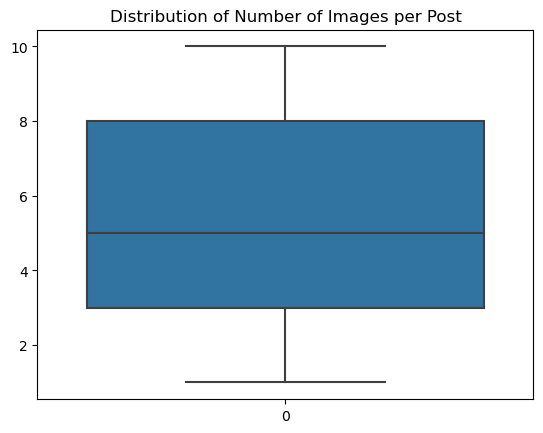

In [99]:
sns.boxplot(cleaned_df['no_of_images'])
plt.title('Distribution of Number of Images per Post')
plt.show()

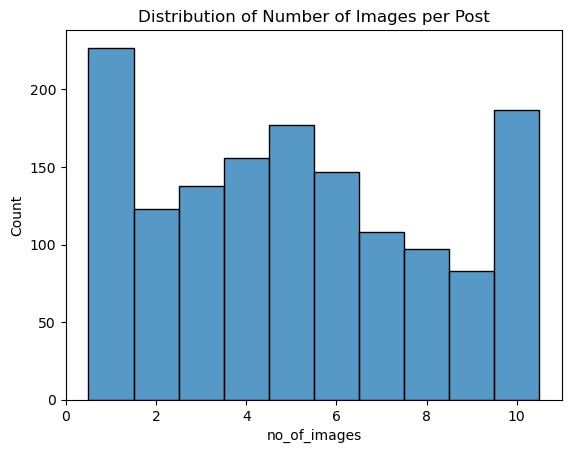

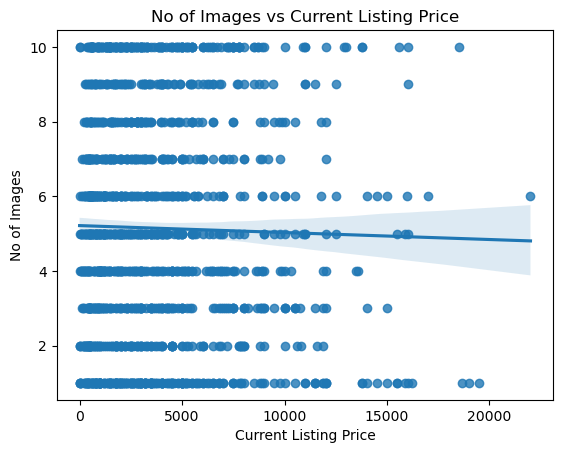

In [96]:
sns.histplot(cleaned_df['no_of_images'], discrete=True)
plt.title('Distribution of Number of Images per Post')
plt.show()

sns.regplot(x='current_listing_price', y='no_of_images', data=cleaned_df)
plt.title('No of Images vs Current Listing Price')
plt.xlabel('Current Listing Price')
plt.ylabel('No of Images')
plt.show()

## Length and word count of posts

In [40]:
# Feature engineering for `posts`
cleaned_df['len_posts'] = cleaned_df['posts'].apply(lambda x: len(x))
cleaned_df['post_word_count'] = cleaned_df['posts'].apply(lambda x: len(x.split()))

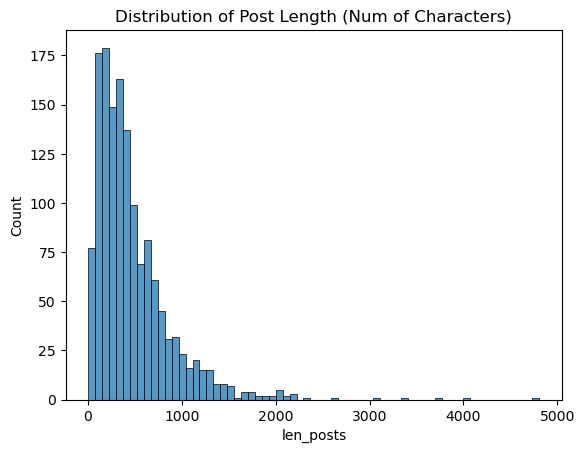

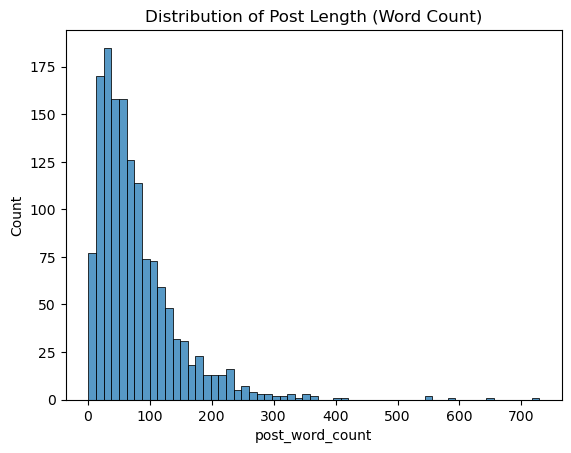

In [97]:
sns.histplot(cleaned_df['len_posts'])
plt.title('Distribution of Post Length (Num of Characters)')
plt.show()

sns.histplot(cleaned_df['post_word_count'])
plt.title('Distribution of Post Length (Word Count)')
plt.show()

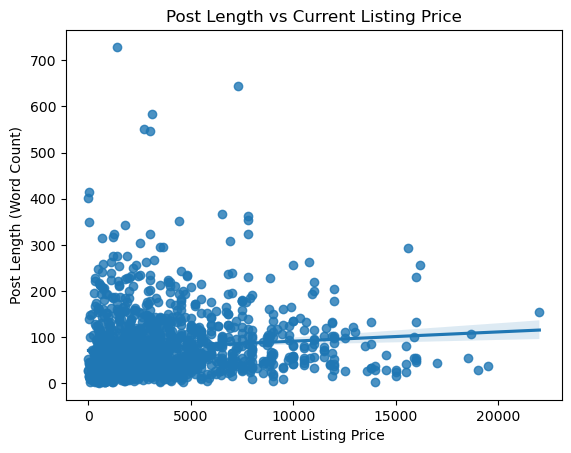

In [94]:
sns.regplot(x='current_listing_price', y='post_word_count', data=cleaned_df)
plt.title('Post Length vs Current Listing Price')
plt.xlabel('Current Listing Price')
plt.ylabel('Post Length (Word Count)')
plt.show()

In [93]:
correlation = cleaned_df['current_listing_price'].corr(cleaned_df['post_word_count'])
print(f"The correlation between 'current_listing_price' and 'post_word_count' is {correlation}")

The correlation between 'current_listing_price' and 'post_word_count' is 0.09731884160645307


## Emoji Use
`cleaned_df['emojis']` and `cleaned_df['num_emojis]` are created to stored the emojis, if any, of each post, as well as the count of emojis.

In [43]:
# Def function to extract emojis if present to a column
def extract_emojis(text):
  return ''.join(c for c in text if c in emoji.EMOJI_DATA)

cleaned_df['emojis'] = cleaned_df['posts'].apply(extract_emojis)

# Create a new column 'num_emojis' containing the number of emojis
cleaned_df['num_emojis'] = cleaned_df['emojis'].apply(lambda x: len(x))

In [44]:
# Count the number of rows for each 'seller_id'
seller_counts = cleaned_df[cleaned_df['num_emojis'] != 0].groupby('seller_id').size()

# Select only the counts greater than 1
seller_counts = seller_counts[seller_counts > 1]

In [45]:
seller_counts

seller_id
autumn_angel_sports_pte_ltd    3
bestroadbikedeals              2
bikeco                         5
bikingmaterial                 2
carlosg1                       2
cycle21                        5
cyclingclub                    2
lobanglisting                  4
nc.directs                     4
oaheij                         2
otahhhh                        2
randomwalker                   3
rideinstyle.sg                 3
shopforyou.sg                  2
dtype: int64

Based on above list, these are likely to be sellers who are shops and have multiple listings.

In [46]:
len(cleaned_df[cleaned_df['num_emojis']!=0])

128

In [47]:
len(cleaned_df[cleaned_df['num_emojis']==0])

1316

Majority of posts do not use emojis.

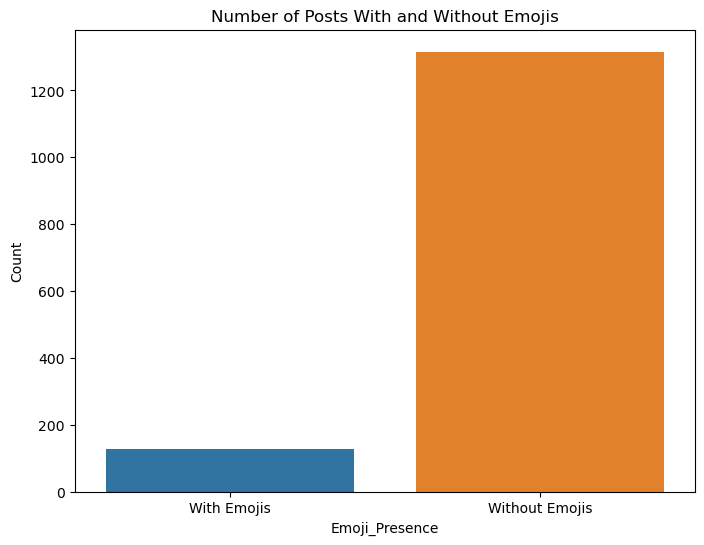

In [48]:
# Calculate the lengths
num_with_emojis = len(cleaned_df[cleaned_df['num_emojis']!=0])
num_without_emojis = len(cleaned_df[cleaned_df['num_emojis']==0])

# Create a new DataFrame to store these values
emoji_df = pd.DataFrame({
    'Emoji_Presence': ['With Emojis', 'Without Emojis'],
    'Count': [num_with_emojis, num_without_emojis]
})

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Emoji_Presence', y='Count', data=emoji_df)
plt.title('Number of Posts With and Without Emojis')
plt.show()

In [49]:
# Check count of emojis

# Initialize Counter
emoji_counter = Counter()

def count_emojis(text):
    global emoji_counter
    count = emoji_count(text)
    if count > 0:
        for c in text:
            if emoji_count(c) > 0:  # If the character is an emoji
                emoji_counter.update(c)  # Update the counter

cleaned_df['posts'].apply(count_emojis)

# Create a DataFrame to display the 20 most common emojis
emoji_df = pd.DataFrame(emoji_counter.most_common(20), columns=["emoji", "count"])
print(emoji_df)

   emoji  count
0      ▪     38
1      ☑     31
2      ✅     28
3      ◾     26
4      🔥     25
5      💡     23
6      👍     20
7      🏼     16
8      ❗     15
9      🟢     14
10     🏻     13
11     ⭐     13
12     🚴     13
13     🔵     13
14     🤝     12
15     ✨     11
16     🚲     10
17     🆕     10
18     🚚     10
19     😊      9


The top 20 most commonly used emojis are are quite generic.

# Exploratory Data Analysis (EDA)

## EDA 1 - Current Listing Price (target variable)

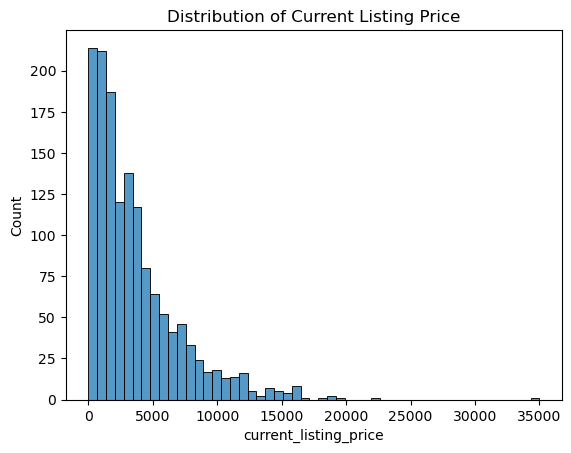

In [50]:
sns.histplot(cleaned_df['current_listing_price'])
plt.title('Distribution of Current Listing Price')
plt.show()

Distribution of current listing price is not normal. We can consider carrying out a transformation prior to modeling.

In [51]:
cleaned_df['current_listing_price'].min()

0.0

In [52]:
cleaned_df['current_listing_price'].max()

34999.0

Listings up to $2500 are most common, with the most expensive listing just under $35,000.

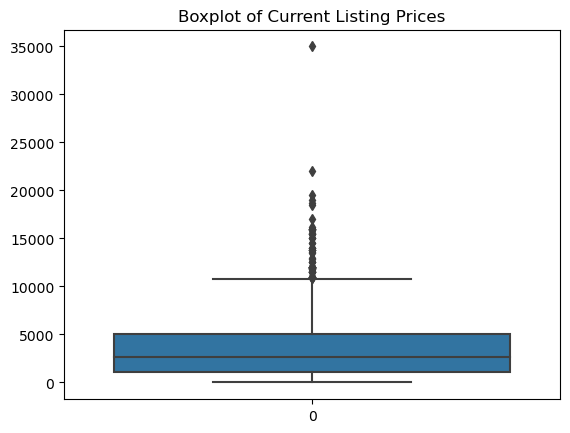

In [53]:
sns.boxplot(cleaned_df['current_listing_price'])
plt.title('Boxplot of Current Listing Prices')
plt.show()

The 1 listing with current_listing_price = 34999 can be considered an outlier. Let's remove it

In [54]:
cleaned_df[cleaned_df['current_listing_price']==34999]

,no_of_likes,no_of_images,title,listing_price,item_condition,deal_method,post_date,category_type,post_type,condition_subtext,listing_description,mailing_option,delivery_options,mail_speed,meetup_option,meetup_location,seller_id,seller_join_date,seller_response,seller_verif,verified_by_email,verified_by_facebook,verified_by_mobile,seller_stars_rating,reviews_of_seller,url,deal_location_lat,deal_location_lon,posts,current_listing_price,last_listing_price,contains_brand,brands,len_posts,post_word_count,emojis,num_emojis
1281,12,10,Time Scylon road bike,"34,999",Lightly used,Meetup,1 week ago,Road Bikes,Posted,"Used with care. Flaws, if any, are barely noti...",Frame: Time Sclyon w/ Aktiv fork ISP frameset ...,N,NaN,NaN,Y,Jurong West Street 91,dntel,Joined 7 years ago,Mostly Responsive,Verified,1.0,1.0,1.0,4.7,17,https://www.carousell.sg/p/time-scylon-road-bi...,NaN,NaN,Time Scylon road bike Frame: Time Sclyon w/ Ak...,34999.0,NaN,True,Look,1276,173,,0


In [55]:
cleaned_df=cleaned_df.drop(index=1281) 

In [56]:
cleaned_df.sort_values(by='current_listing_price').head()

,no_of_likes,no_of_images,title,listing_price,item_condition,deal_method,post_date,category_type,post_type,condition_subtext,listing_description,mailing_option,delivery_options,mail_speed,meetup_option,meetup_location,seller_id,seller_join_date,seller_response,seller_verif,verified_by_email,verified_by_facebook,verified_by_mobile,seller_stars_rating,reviews_of_seller,url,deal_location_lat,deal_location_lon,posts,current_listing_price,last_listing_price,contains_brand,brands,len_posts,post_word_count,emojis,num_emojis
1077,3,1,Factor Ostro Frameset,0,Well used,Meetup,2 days ago,Road Bikes,Posted,Has minor flaws or defects.,🟢Factor Ostro Vam (54)\n🟢British Racing Green\...,N,NaN,NaN,Y,Sembawang Shopping CentreCanberra MRT Station ...,nc.directs,Joined 7 years ago,Very Responsive,Verified,1.0,1.0,1.0,4.7,46,https://www.carousell.sg/p/factor-ostro-frames...,NaN,NaN,Factor Ostro Frameset 🟢Factor Ostro Vam (54)\n...,0.0,NaN,True,"Factor, Factor",182,28,🟢🟢🟢🟢,4
4512,7,1,Factor Ostro Frameset,0,Well used,Meetup,1 week ago,Road Bikes,Posted,Has minor flaws or defects.,🟢Factor Ostro Vam (54)\n🟢British Racing Green\...,N,NaN,NaN,Y,Sembawang Shopping CentreCanberra MRT Station ...,nc.directs,Joined 7 years ago,Very Responsive,Verified,NaN,NaN,NaN,4.8,48,https://www.carousell.sg/p/factor-ostro-frames...,1.441590,103.824456,Factor Ostro Frameset 🟢Factor Ostro Vam (54)\n...,0.0,NaN,True,"Factor, Factor",174,27,🟢🟢🟢🟢,4
837,17,1,About us,0,Brand new,Meetup,2 weeks ago,Road Bikes,Bumped,Never used. May come with original packaging o...,Welcome to Sengkangbikeshop:)\r\n\r\nWe specia...,N,NaN,NaN,Y,"Block 331, Anchorvale Street",sengkangbikeshop,Joined 6 years ago,Very Responsive,Verified,1.0,0.0,1.0,4.9,90,https://www.carousell.sg/p/about-us-1160769670...,NaN,NaN,About us Welcome to Sengkangbikeshop:)\r\n\r\n...,0.0,NaN,True,"Trek, trek, Canyon, specialize, specialized, s...",2357,401,,0
1555,10,2,Felt ZW6,0,Lightly used,Meetup,2 months ago,Road Bikes,Posted,"Used with care. Flaws, if any, are barely noti...",Selling Felt ZW6 which was bought end Jun 2021...,N,NaN,NaN,Y,Yew Tee,nyanmawhtoo,Joined 9 years ago,Very Responsive,Verified,1.0,1.0,1.0,5.0,34,https://www.carousell.sg/p/felt-zw6-1230554918...,NaN,NaN,Felt ZW6 Selling Felt ZW6 which was bought end...,0.0,NaN,True,"Felt, Felt",315,53,,0
4301,3,6,Cycling jersey,10 30,Brand new,Meetup,5 days ago,Road Bikes,Posted,Never used. May come with original packaging o...,3 jersey for $25 \nGiant jersey size L \nThe o...,N,NaN,NaN,Y,Tampines East MRT Station (DT33),roystonng,Joined 8 years ago,Very Responsive,Verified,NaN,NaN,NaN,5.0,56,https://www.carousell.sg/p/cycling-jersey-1243...,1.356247,103.954837,Cycling jersey 3 jersey for $25 \nGiant jersey...,10.0,30.0,True,Giant,76,16,,0


## EDA 2 - Word Frequency Visualisations

In [57]:
# Def function to clean text:
#   - remove links
#   - replace'\r' and '\n'
#   - remove emojis
# Numbers are not removed for now as some parts of bicycles are alpha-numeric in nature.

def clean_text(text):
    # remove links starting with 'http' or 'www'
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    # replace '\r' and/or '\n' with spacing
    text = re.sub('[\n\r]+', '\n', text)
    text = text.replace('\n', ' ')
    # remove emojis
    return emoji.replace_emoji(text, replace='')

In [58]:
cleaned_df['posts'] = cleaned_df['posts'].apply(clean_text)

In [59]:
# Def function to lemmatize text.
punctuation = string.punctuation # Modify punctuation here if needed

nlp = spacy.load("en_core_web_sm")
# Use nlp.pipe from SpaCy to process text
# token.lemma_.lower(): for each token, get lemma, convert to lowercase
# if token.text not in punctuation and token.is_stop == False: 
# this removes punctuation and stop words in SpaCy's nlp model

def lemmatize_texts(texts):
    lemmatized_texts = []
    for doc in nlp.pipe(texts):
        lemmatized_text = " ".join([token.lemma_.lower() for token in doc if token.text not in punctuation and token.is_stop == False])
        lemmatized_texts.append(lemmatized_text)
    return lemmatized_texts

In [60]:
cleaned_df['lemma_posts'] = lemmatize_texts(cleaned_df['posts'])

## A. Count Vectorizer (Single Word)

In [61]:
count_vect = CountVectorizer()
X_count_vect = count_vect.fit_transform(cleaned_df['lemma_posts'])
print('Shape of vectorised dataset:', X_count_vect.shape)

Shape of vectorised dataset: (1443, 7093)


In [62]:
X_count_vect_df = pd.DataFrame(X_count_vect.todense(), 
                              columns=count_vect.get_feature_names_out())

In [63]:
top30_count_vect = X_count_vect_df.sum().sort_values(ascending=False).reset_index().head(30)

In [64]:
top30_count_vect

,index,0
0,bike,1948
1,size,1348
2,carbon,1320
3,shimano,1174
4,mm,1037
5,frame,815
6,ultegra,773
7,giant,684
8,new,659
9,road,614


## B. TF-IDF Vectorizer (Single Word)

In [65]:
tfidf_vect = TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2)
X_tfidf_vect = tfidf_vect.fit_transform(cleaned_df['lemma_posts'])
print('Shape of vectorised dataset:', X_tfidf_vect.shape)

Shape of vectorised dataset: (1443, 3797)


In [66]:
X_tfidf_vect_df = pd.DataFrame(X_tfidf_vect.todense(), 
                              columns=tfidf_vect.get_feature_names_out())

In [67]:
top30_tfidf_vect = X_tfidf_vect_df.sum().sort_values(ascending=False).reset_index().head(30)

In [68]:
top30_tfidf_vect

,index,0
0,bike,81.502155
1,carbon,63.076481
2,size,57.816852
3,shimano,55.370326
4,giant,54.211044
5,mm,48.915705
6,ultegra,45.963116
7,frame,44.941557
8,road,42.735090
9,new,40.112328


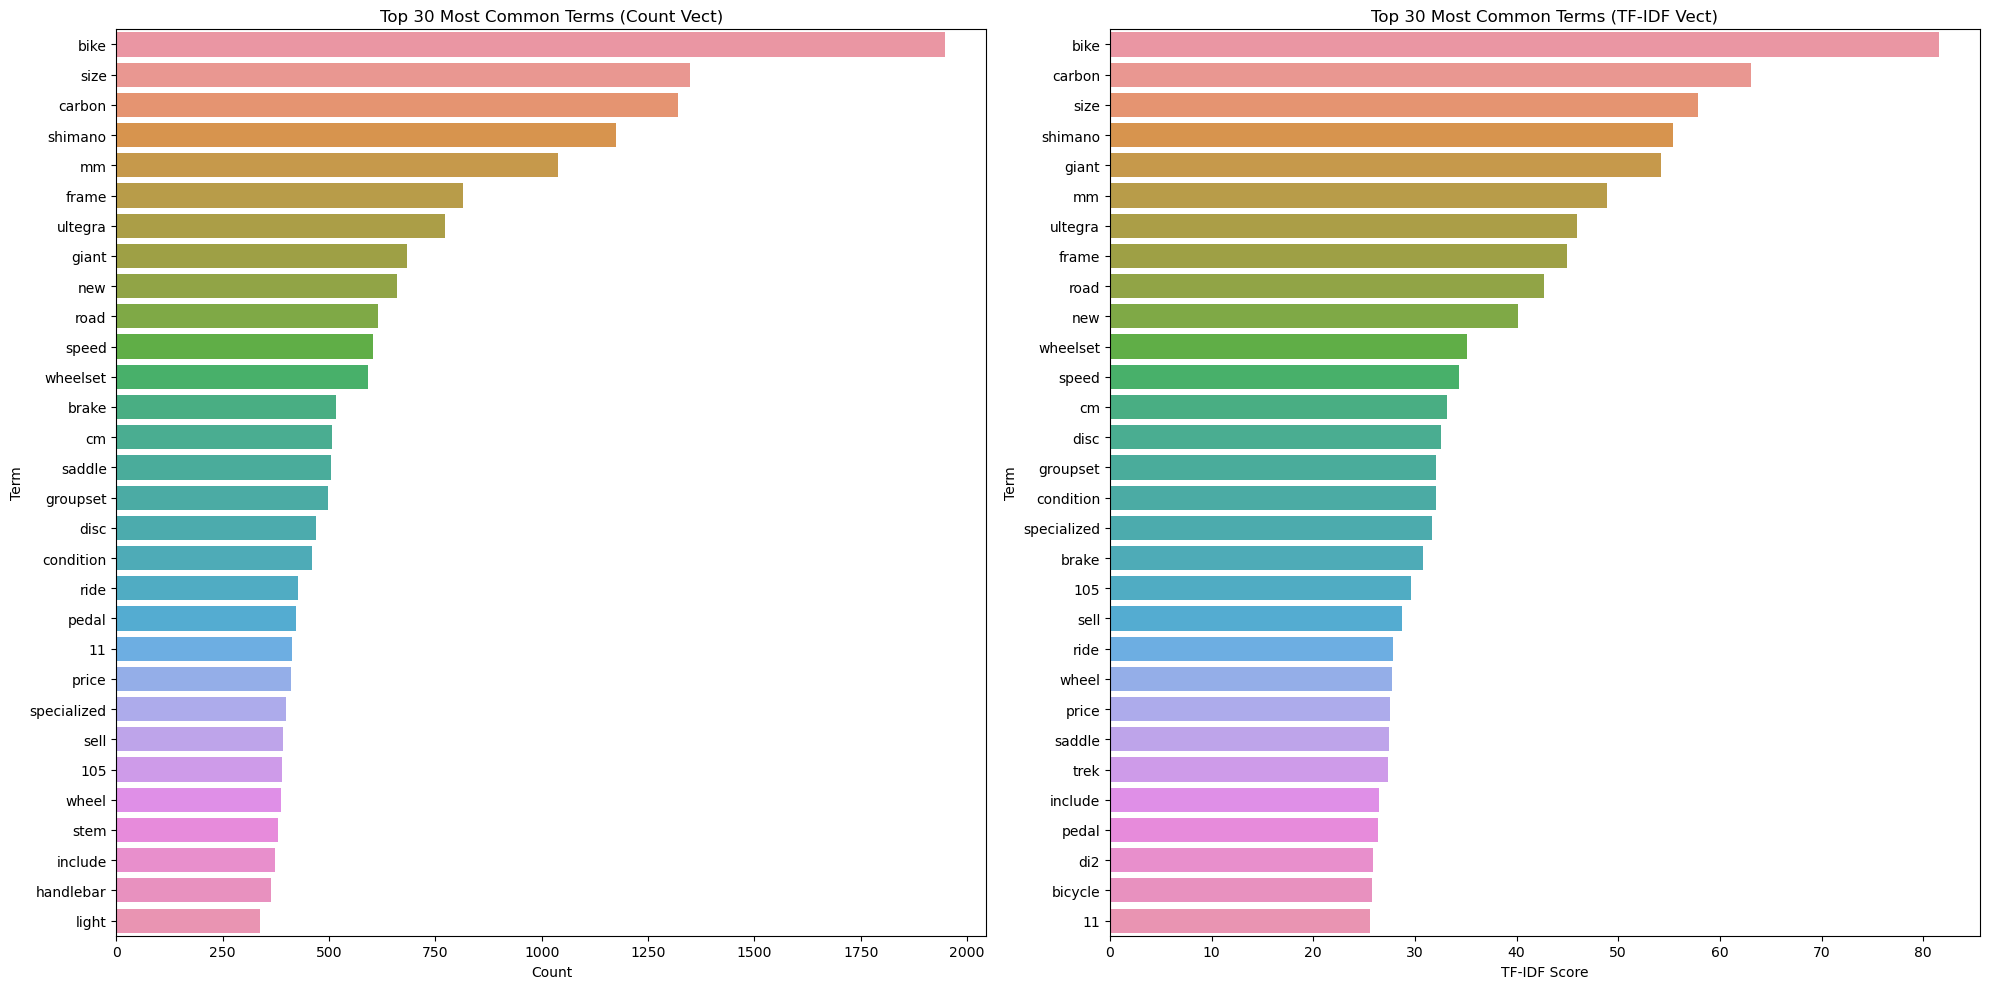

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plot Count Vectorizer results
sns.barplot(data=top30_count_vect, x=0, y='index', ax=ax[0])
ax[0].set_title('Top 30 Most Common Terms (Count Vect)')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Term')

# Plot Tfidf Vectorizer results
sns.barplot(data=top30_tfidf_vect, x=0, y='index', ax=ax[1])
ax[1].set_title('Top 30 Most Common Terms (TF-IDF Vect)')
ax[1].set_xlabel('TF-IDF Score')
ax[1].set_ylabel('Term')

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure.
plt.show()

## C. Count Vectoriser (Bigram)

In [70]:
bigram_vect = CountVectorizer(ngram_range=(2,2))
X_bigram_vect = bigram_vect.fit_transform(cleaned_df['lemma_posts'])
print('Shape of vectorised dataset:', X_bigram_vect.shape)

Shape of vectorised dataset: (1443, 42953)


In [71]:
X_bigram_vect_df = pd.DataFrame(X_bigram_vect.todense(), 
                              columns=bigram_vect.get_feature_names_out())

In [72]:
top30_bigram_vect = X_bigram_vect_df.sum().sort_values(ascending=False).reset_index().head(30)

In [73]:
top30_bigram_vect

,index,0
0,road bike,438
1,shimano ultegra,322
2,shimano 105,274
3,dura ace,254
4,bottle cage,198
5,brand new,189
6,11 speed,183
7,giant tcr,175
8,size 54,146
9,carbon wheelset,119


## D. TF-IDF Vectorizer (Bigram)

In [74]:
tfidf_bigram_vect = TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2, ngram_range=(2,2))
X_tfidf_bigram_vect = tfidf_bigram_vect.fit_transform(cleaned_df['lemma_posts'])
print('Shape of vectorised dataset:', X_tfidf_bigram_vect.shape)

Shape of vectorised dataset: (1443, 5000)


In [75]:
X_tfidf_bigram_vect_df = pd.DataFrame(X_tfidf_bigram_vect.todense(), 
                              columns=tfidf_bigram_vect.get_feature_names_out())

In [76]:
top30_tfidf_bigram_vect = X_tfidf_bigram_vect_df.sum().sort_values(ascending=False).reset_index().head(30)

In [77]:
top30_tfidf_bigram_vect

,index,0
0,road bike,44.282667
1,shimano ultegra,27.332771
2,shimano 105,25.472844
3,dura ace,23.446061
4,giant tcr,22.158925
5,brand new,19.176856
6,bottle cage,17.770535
7,size 54,17.619890
8,11 speed,17.457232
9,size 52,15.580208


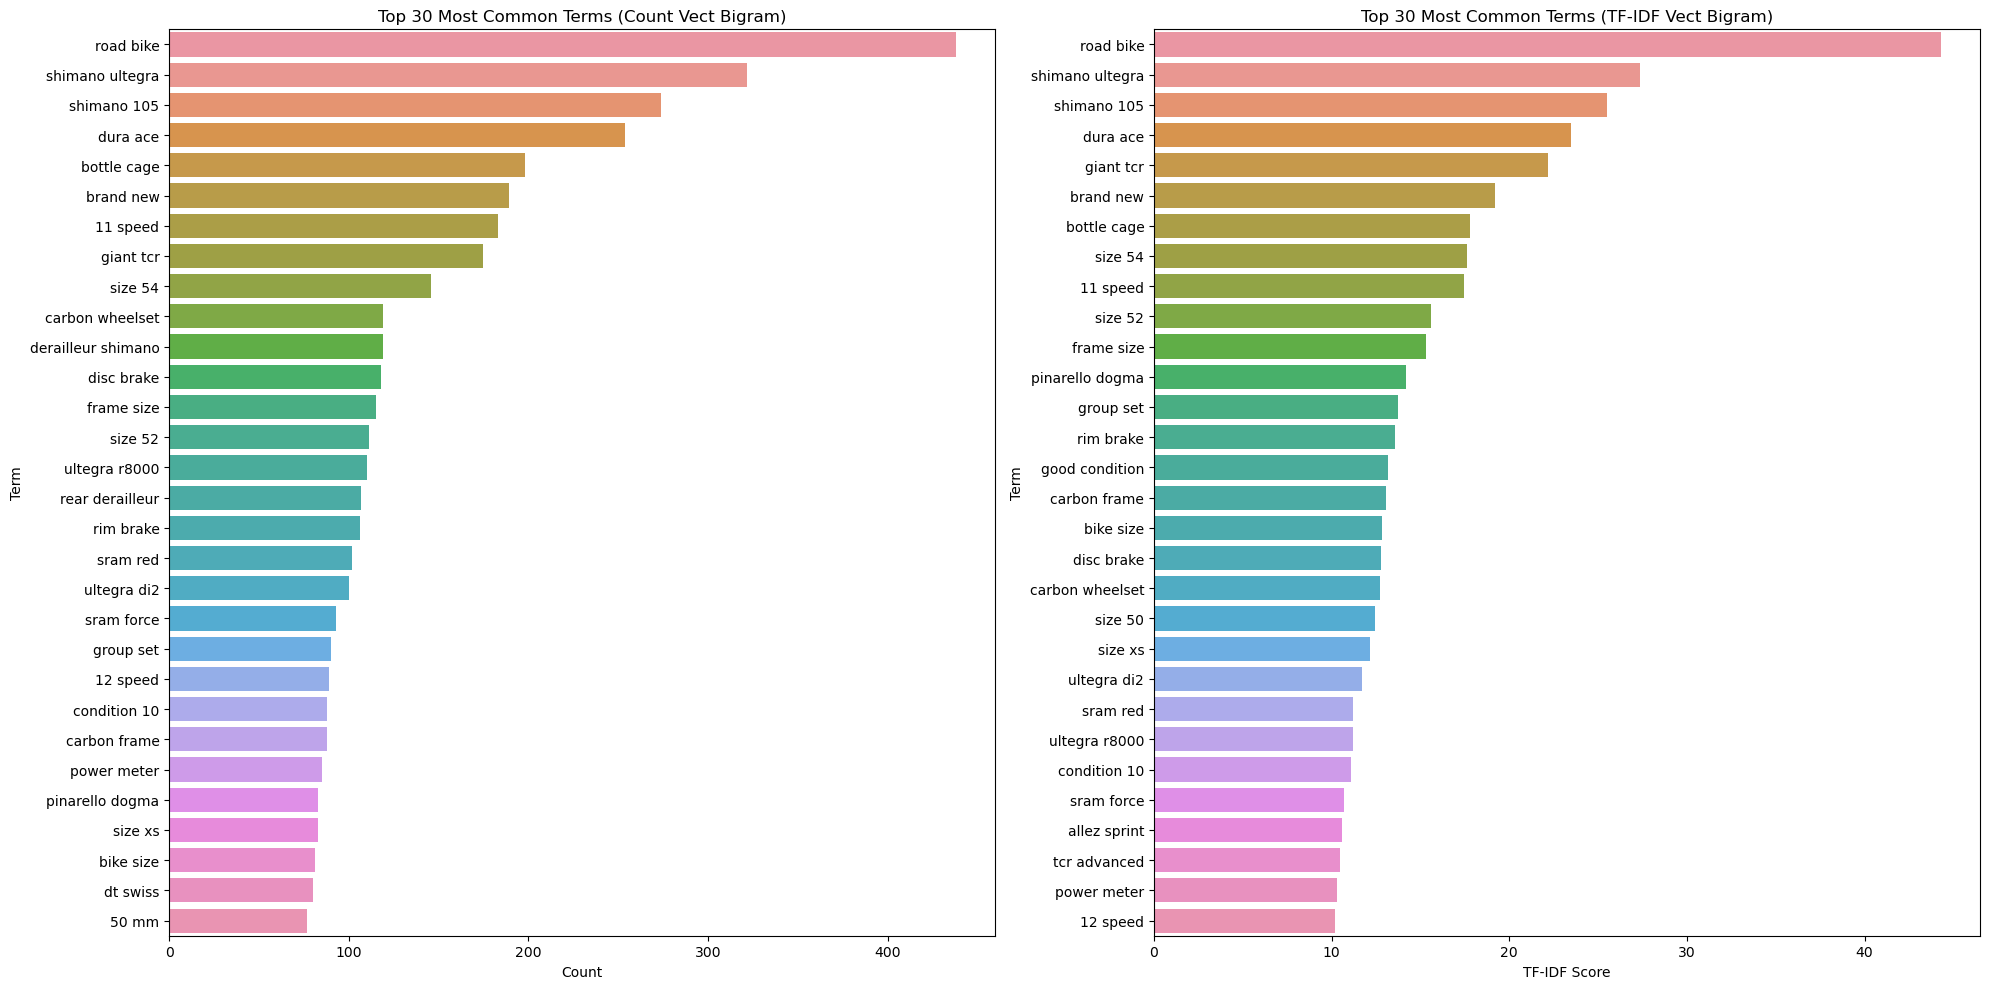

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plot Count Vectorizer Bigram results
sns.barplot(data=top30_bigram_vect, x=0, y='index', ax=ax[0])
ax[0].set_title('Top 30 Most Common Terms (Count Vect Bigram)')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Term')

# Plot Tfidf Vectorizer Bigram results
sns.barplot(data=top30_tfidf_bigram_vect, x=0, y='index', ax=ax[1])
ax[1].set_title('Top 30 Most Common Terms (TF-IDF Vect Bigram)')
ax[1].set_xlabel('TF-IDF Score')
ax[1].set_ylabel('Term')

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure.
plt.show()

## E. Count Vectorizer (Trigram)

In [79]:
trigram_vect = CountVectorizer(ngram_range=(3,3))
X_trigram_vect = trigram_vect.fit_transform(cleaned_df['lemma_posts'])
print('Shape of vectorised dataset:', X_trigram_vect.shape)

Shape of vectorised dataset: (1443, 61959)


In [80]:
X_trigram_vect_df = pd.DataFrame(X_trigram_vect.todense(), 
                              columns=trigram_vect.get_feature_names_out())

In [81]:
top30_trigram_vect = X_trigram_vect_df.sum().sort_values(ascending=False).reset_index().head(30)

In [82]:
top30_trigram_vect

,index,0
0,giant tcr advanced,69
1,shimano ultegra r8000,59
2,rear derailleur shimano,57
3,carbon road bike,54
4,shimano dura ace,47
5,shimano 105 r7000,45
6,derailleur shimano ultegra,42
7,giant tcr advance,40
8,specialized allez sprint,39
9,dura ace di2,39


## F. TF-IDF Vectorizer (Bigram)

In [83]:
tfidf_trigram_vect = TfidfVectorizer(max_df=0.9, max_features=5000, min_df=2, ngram_range=(3,3))
X_tfidf_trigram_vect = tfidf_trigram_vect.fit_transform(cleaned_df['lemma_posts'])
print('Shape of vectorised dataset:', X_tfidf_trigram_vect.shape)

Shape of vectorised dataset: (1443, 5000)


In [84]:
X_tfidf_trigram_vect_df = pd.DataFrame(X_tfidf_trigram_vect.todense(), 
                              columns=tfidf_trigram_vect.get_feature_names_out())

In [85]:
top30_tfidf_trigram_vect = X_tfidf_trigram_vect_df.sum().sort_values(ascending=False).reset_index().head(30)

In [86]:
top30_tfidf_trigram_vect

,index,0
0,giant tcr advanced,13.420185
1,carbon road bike,13.227442
2,road bike size,11.222047
3,specialized allez sprint,9.998508
4,giant tcr advance,9.857072
5,shimano dura ace,8.960078
6,shimano ultegra r8000,8.673536
7,dura ace di2,7.931370
8,shimano 105 groupset,7.386817
9,shimano 105 r7000,7.238714


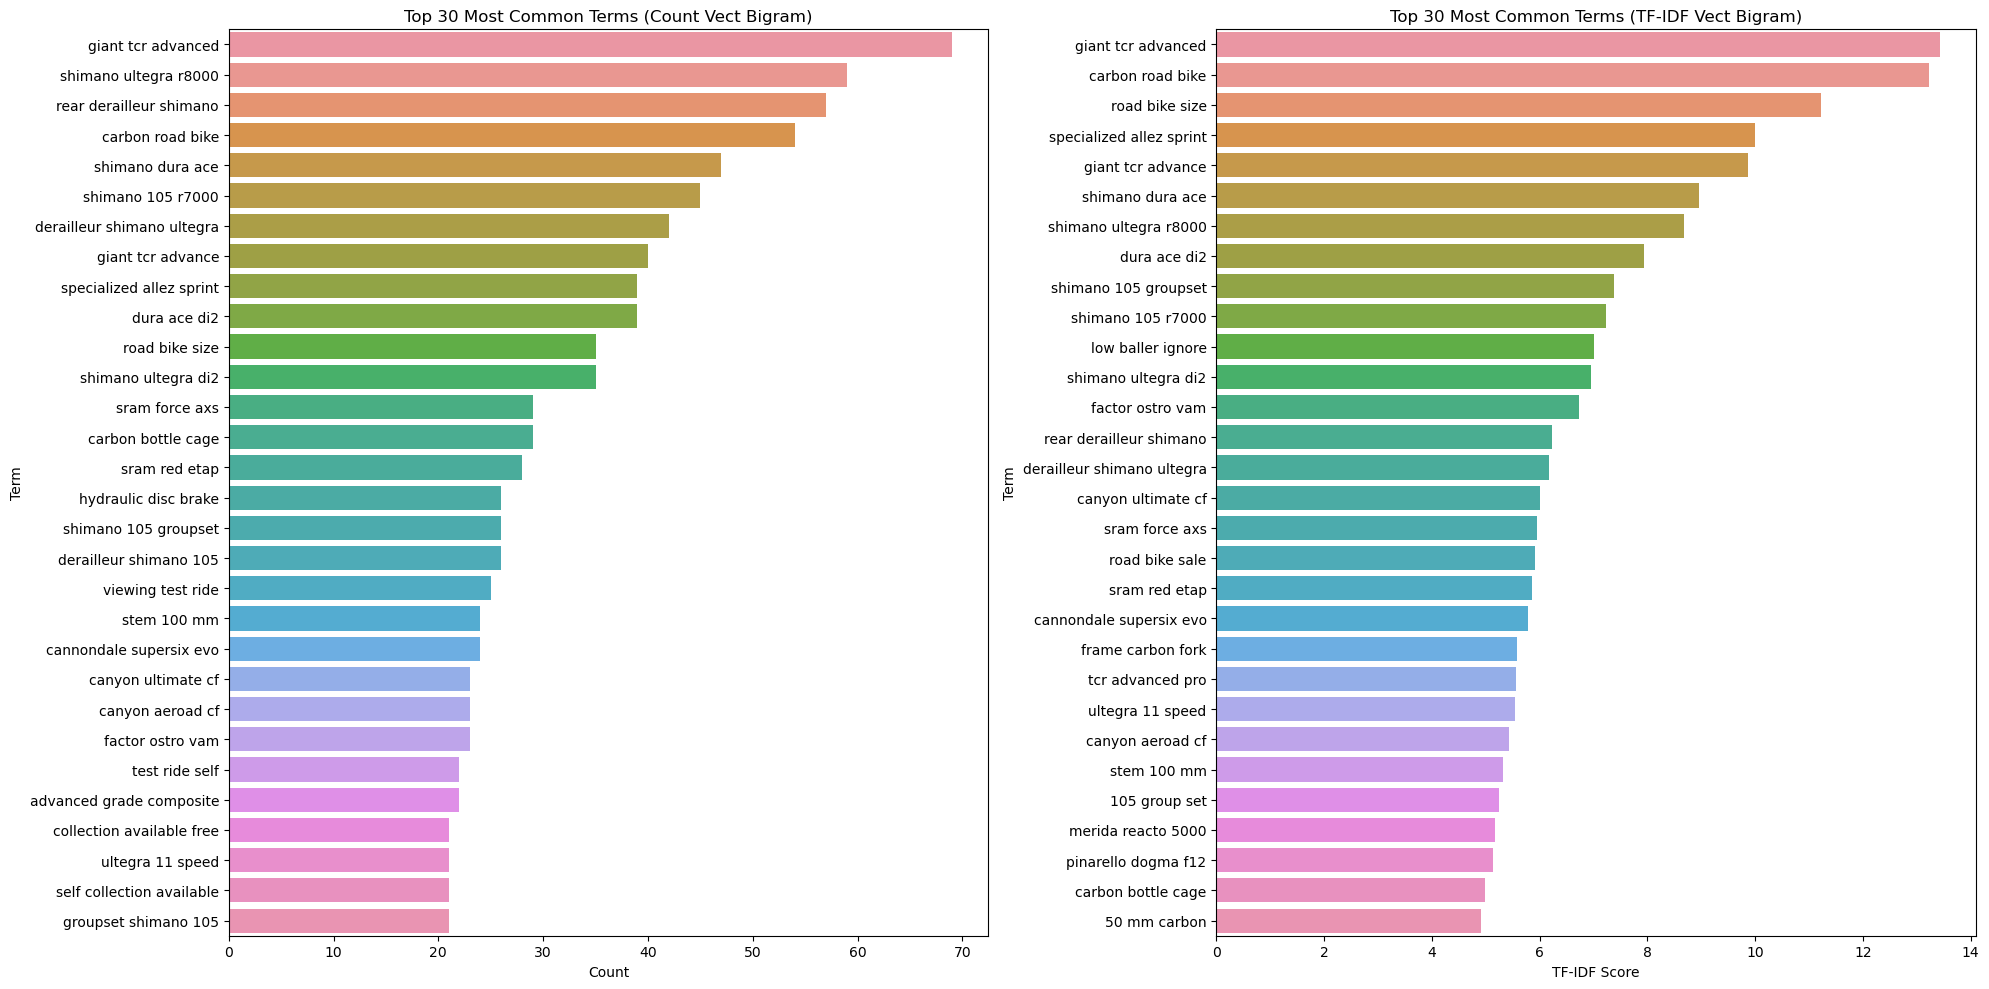

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plot Count Vectorizer Trigram results
sns.barplot(data=top30_trigram_vect, x=0, y='index', ax=ax[0])
ax[0].set_title('Top 30 Most Common Terms (Count Vect Bigram)')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Term')

# Plot Tfidf Vectorizer Bigram results
sns.barplot(data=top30_tfidf_trigram_vect, x=0, y='index', ax=ax[1])
ax[1].set_title('Top 30 Most Common Terms (TF-IDF Vect Bigram)')
ax[1].set_xlabel('TF-IDF Score')
ax[1].set_ylabel('Term')

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure.
plt.show()

In [88]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443 entries, 0 to 7561
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   no_of_likes            1443 non-null   int64  
 1   no_of_images           1443 non-null   int64  
 2   title                  1443 non-null   object 
 3   listing_price          1443 non-null   object 
 4   item_condition         1443 non-null   object 
 5   deal_method            1443 non-null   object 
 6   post_date              1443 non-null   object 
 7   category_type          1443 non-null   object 
 8   post_type              1443 non-null   object 
 9   condition_subtext      1443 non-null   object 
 10  listing_description    1443 non-null   object 
 11  mailing_option         1443 non-null   object 
 12  delivery_options       116 non-null    object 
 13  mail_speed             116 non-null    object 
 14  meetup_option          1443 non-null   object 
 15  meet

In [89]:
# Save cleaned_df to csv

current_directory = os.getcwd()
csv_file_path = os.path.join(current_directory, '../data', 'cleaned_df.csv')

cleaned_df.to_csv(csv_file_path, index=False)